# ML Project Skeleton
link to dataset:

Goal: 

The project is organized as follows:


1. EDA, Understanding the Data

2. Model Building Idea, Functions for Visualization

3. Model Building

[Ozone Data](https://aqs.epa.gov/aqsweb/airdata/download_files.html#Raw)

[Worst Ranking Ozone Levels](https://www.lung.org/research/sota/city-rankings/most-polluted-cities)

[Historical Weather Data](https://visualcrossing.com/)

[Weather Data Documentation](https://www.visualcrossing.com/resources/documentation/weather-data/weather-data-documentation/)

[Effect of Weekends](https://www.tandfonline.com/doi/full/10.1080/10962247.2012.749312#:~:text=In%20simple%20terms%2C%20the%20ozone,NOx\)%2C%20on%20weekends.)

# Utilities, Constants

In [1]:
def calculate_percent_missing(in_df):
    # function which returns a dataframe indicating what percent of a column is missing
    percent_missing = in_df.isnull().sum() * 100 / len(in_df)
    return pd.DataFrame({'percent_missing': percent_missing})
def summary_of_model(clf, X_train, X_test, y_train, y_test):
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import accuracy_score, precision_score, recall_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
    # This provides a summary of the model, but without the threshold condition.
    # It includes a summary on recall/accuracy on the training and test sets, a visual display of the confusion matrix
    # and a plot of the precision-recall curve for a given classifier.
    pred_test = clf.predict(X_test)
    pred_train = clf.predict(X_train)
    print(classification_report(y_test, pred_test))
    print('Recall on the training set: {:.2f}'.format(recall_score(y_train, pred_train)))
    print('Accuracy on the training set: {:.2f}'.format(accuracy_score(y_train, pred_train)))
    print('Recall on the test set: {:.2f}'.format(recall_score(y_test, pred_test)))
    print('Accuracy on the test set: {:.2f}'.format(accuracy_score(y_test, pred_test)))
    print(confusion_matrix(y_test, pred_test))
    _, ax = plt.subplots(figsize=(9,9))
    ax = sns.heatmap(confusion_matrix(y_test, pred_test), annot=True, fmt='d', cmap='vlag', annot_kws={"size": 40, "weight": "bold"})  
    labels = ['False', 'True']
    ax.set_xticklabels(labels, fontsize=25);
    ax.set_yticklabels(labels, fontsize=25);
    ax.set_ylabel('Actual', fontsize=30);
    ax.set_xlabel('Prediction', fontsize=30)
    lr_probs = clf.predict_proba(X_test)
    lr_probs = lr_probs[:, 1]
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
    plt.figure()
    plt.plot(lr_recall, lr_precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

In [2]:
TEST_FRACTION = .25 #percentage of the test size
CV = 7 #cross validations to do in grid search
OPT_ON = 'f1' #what to optimize in gridsearches
N_JOBS = 7 #number of cores
RAND_STATE = 0 #will be doing multiple train-test-splits, and want to keep everything random, but do the same train-test-splits

# Deployment

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('data/ozone_2019.csv')

/home/jcummings/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
df_col_weather = pd.read_csv('data/denver_weather_2019_real.csv')

In [30]:
df_col_weather

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,"39.75, -104.987625",2018-01-01T00:00:00,8.1,0.7,4.1,83.40,0.0,NaN,NaN,0.0,...,1033.6,74.2,9.1,NaN,NaN,0,NaN,Partially cloudy,partly-cloudy-night,"KBKF,KDEN,72469523036,KAPA,72565003017,7246669..."
1,"39.75, -104.987625",2018-01-01T01:00:00,8.2,8.2,4.2,83.54,0.0,NaN,NaN,0.0,...,1033.7,100.0,9.1,NaN,NaN,0,NaN,Overcast,cloudy,"KBKF,KDEN,72469523036,KAPA,72565003017,7246669..."
2,"39.75, -104.987625",2018-01-01T02:00:00,9.8,9.8,5.8,83.63,0.0,NaN,NaN,0.0,...,1032.9,82.6,9.2,NaN,NaN,0,NaN,Partially cloudy,partly-cloudy-night,"KBKF,KDEN,72469523036,KAPA,72565003017,7246669..."
3,"39.75, -104.987625",2018-01-01T03:00:00,9.1,9.1,6.3,88.11,0.0,NaN,NaN,0.0,...,1033.1,47.2,9.2,NaN,NaN,0,NaN,Partially cloudy,partly-cloudy-night,"KBKF,72469523036,KAPA,72565003017,72466693067"
4,"39.75, -104.987625",2018-01-01T04:00:00,8.2,2.3,5.1,87.12,0.0,NaN,NaN,0.0,...,1032.4,31.0,7.8,NaN,NaN,0,NaN,Partially cloudy,partly-cloudy-night,"KBKF,KDEN,72469523036,KAPA,72565003017,7246669..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,"39.75, -104.987625",2020-01-01T19:00:00,38.3,31.6,19.8,46.77,0.0,NaN,NaN,0.0,...,998.3,27.5,9.9,NaN,NaN,0,NaN,Partially cloudy,partly-cloudy-night,"KBKF,KDEN,72469523036,KAPA,72565003017,7246669..."
17540,"39.75, -104.987625",2020-01-01T20:00:00,35.9,27.5,19.6,51.26,0.0,NaN,NaN,0.0,...,998.5,27.5,9.9,NaN,NaN,0,NaN,Partially cloudy,partly-cloudy-night,"KBKF,KDEN,72469523036,KAPA,72565003017,7246669..."
17541,"39.75, -104.987625",2020-01-01T21:00:00,35.6,27.5,19.4,51.23,0.0,NaN,NaN,0.0,...,998.5,27.5,9.9,NaN,NaN,0,NaN,Partially cloudy,partly-cloudy-night,"KBKF,KDEN,72469523036,KAPA,72565003017,7246669..."
17542,"39.75, -104.987625",2020-01-01T22:00:00,34.4,26.6,19.2,53.53,0.0,NaN,NaN,0.0,...,998.2,27.5,9.9,NaN,NaN,0,NaN,Partially cloudy,partly-cloudy-night,"KBKF,KDEN,72469523036,KAPA,72565003017,7246669..."


# 1. EDA, Understanding the Data
Summary 

## Parameters and useful functions for analysis

In [31]:
df.columns = df.columns.str.lower()
df.columns = df.columns.str.strip()
df.describe()

,state code,county code,site num,parameter code,poc,latitude,longitude,sample measurement,mdl,uncertainty,method code
count,9.142786e+06,9.142786e+06,9.142786e+06,9142786.0,9.142786e+06,9.142786e+06,9.142786e+06,9.142786e+06,9.142786e+06,0.0,9.142786e+06
mean,2.668803e+01,7.627163e+01,1.344786e+03,44201.0,1.084851e+00,3.758337e+01,-9.520775e+01,3.078728e-02,1.397212e-01,NaN,7.220774e+01
std,1.684961e+01,8.080285e+01,2.670646e+03,0.0,3.483333e-01,4.926934e+00,1.619993e+01,1.481152e-02,8.220645e-01,NaN,4.150573e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,44201.0,1.000000e+00,1.821604e+01,-1.580886e+02,-4.000000e-03,6.000000e-04,NaN,1.900000e+01
25%,1.000000e+01,2.300000e+01,6.000000e+00,44201.0,1.000000e+00,3.406957e+01,-1.101827e+02,2.100000e-02,5.000000e-03,NaN,4.700000e+01
50%,2.600000e+01,5.900000e+01,2.500000e+01,44201.0,1.000000e+00,3.835655e+01,-9.121356e+01,3.100000e-02,5.000000e-03,NaN,8.700000e+01
75%,4.200000e+01,1.030000e+02,1.015000e+03,44201.0,1.000000e+00,4.095960e+01,-8.213125e+01,4.100000e-02,5.000000e-03,NaN,8.700000e+01
max,8.000000e+01,8.000000e+02,9.997000e+03,44201.0,6.000000e+00,6.484569e+01,-6.612653e+01,1.600000e-01,8.000000e+00,NaN,9.010000e+02


In [32]:
df.columns

Index(['state code', 'county code', 'site num', 'parameter code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter name', 'date local',
       'time local', 'date gmt', 'time gmt', 'sample measurement',
       'units of measure', 'mdl', 'uncertainty', 'qualifier', 'method type',
       'method code', 'method name', 'state name', 'county name',
       'date of last change'],
      dtype='object')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9142786 entries, 0 to 9142785
Data columns (total 24 columns):
 #   Column               Dtype  
---  ------               -----  
 0   state code           int64  
 1   county code          int64  
 2   site num             int64  
 3   parameter code       int64  
 4   poc                  int64  
 5   latitude             float64
 6   longitude            float64
 7   datum                object 
 8   parameter name       object 
 9   date local           object 
 10  time local           object 
 11  date gmt             object 
 12  time gmt             object 
 13  sample measurement   float64
 14  units of measure     object 
 15  mdl                  float64
 16  uncertainty          float64
 17  qualifier            object 
 18  method type          object 
 19  method code          int64  
 20  method name          object 
 21  state name           object 
 22  county name          object 
 23  date of last change  object 
dty

In [34]:
df['county code'].unique()

array([  3,  33,  49,  51,  55,  69,  73,  89,  97, 101, 103, 113, 117,
       119, 125,  68,  90,   5,   7,  12,  13,  17,  19,  21,  25,  27,
        35, 143,   1,   9,  11,  23,  29,  31,  37,  39,  41,  43,  45,
        47,  53,  57,  59,  61,  65,  67,  71,  75,  77,  79,  81,  83,
        85,  87,  93,  95,  99, 107, 109, 111, 123,  15,  86,  91, 105,
       115, 127, 129, 121, 135, 151, 213, 215, 231, 245, 247, 261, 157,
       161, 163, 167, 197, 201,  63, 141, 145, 169, 173, 137, 147, 153,
       177, 133, 191, 195, 209, 139, 175, 185, 193, 199, 221, 227, 229,
       510, 165, 171, 183, 186, 189, 159, 179, 155, 187, 203, 251, 257,
       309, 339, 349, 355, 361, 367, 373, 381, 397, 423, 439, 453, 469,
       479,  36, 650, 800,  26])

In [35]:
df_col_oz = df.loc[(df['county name']=='Denver') & (df['state name']=='Colorado')]

<AxesSubplot:xlabel='sample measurement', ylabel='Count'>

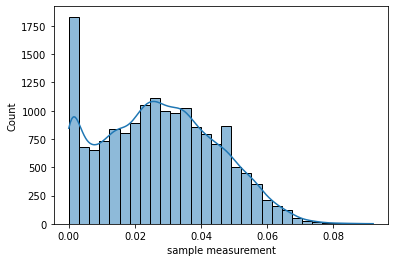

In [36]:
sns.histplot(df_col_oz['sample measurement'], kde = True, bins=30)

In [37]:
df_col_oz.head()

,state code,county code,site num,parameter code,poc,latitude,longitude,datum,parameter name,date local,...,units of measure,mdl,uncertainty,qualifier,method type,method code,method name,state name,county name,date of last change
1999057,8,31,2,44201,6,39.751184,-104.987625,WGS84,Ozone,2019-01-01,...,Parts per million,0.005,NaN,NaN,FEM,87,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,Colorado,Denver,2019-03-15
1999058,8,31,2,44201,6,39.751184,-104.987625,WGS84,Ozone,2019-01-01,...,Parts per million,0.005,NaN,NaN,FEM,87,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,Colorado,Denver,2019-03-15
1999059,8,31,2,44201,6,39.751184,-104.987625,WGS84,Ozone,2019-01-01,...,Parts per million,0.005,NaN,NaN,FEM,87,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,Colorado,Denver,2019-03-15
1999060,8,31,2,44201,6,39.751184,-104.987625,WGS84,Ozone,2019-01-01,...,Parts per million,0.005,NaN,NaN,FEM,87,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,Colorado,Denver,2019-03-15
1999061,8,31,2,44201,6,39.751184,-104.987625,WGS84,Ozone,2019-01-01,...,Parts per million,0.005,NaN,NaN,FEM,87,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,Colorado,Denver,2019-03-15


In [38]:
df_col_oz['latitude'].unique()

array([39.751184, 39.77949 ])

In [39]:
len(df_col_oz.loc[df_col_oz['latitude']==39.77949, 'date local'].unique())

342

In [40]:
len(df_col_oz.loc[df_col_oz['latitude']==39.751184, 'date local'].unique())

361

In [41]:
df_col_oz = df_col_oz[df_col_oz['latitude']==39.751184]

In [42]:
df_col_oz.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8639 entries, 1999057 to 2007695
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state code           8639 non-null   int64  
 1   county code          8639 non-null   int64  
 2   site num             8639 non-null   int64  
 3   parameter code       8639 non-null   int64  
 4   poc                  8639 non-null   int64  
 5   latitude             8639 non-null   float64
 6   longitude            8639 non-null   float64
 7   datum                8639 non-null   object 
 8   parameter name       8639 non-null   object 
 9   date local           8639 non-null   object 
 10  time local           8639 non-null   object 
 11  date gmt             8639 non-null   object 
 12  time gmt             8639 non-null   object 
 13  sample measurement   8639 non-null   float64
 14  units of measure     8639 non-null   object 
 15  mdl                  8639 non

In [43]:
df_col_oz['mdl'].unique()

array([0.005])

In [44]:
df_col_oz['qualifier'].unique()

array([nan], dtype=object)

In [45]:
useful_cols = ['date local', 'time local', 'sample measurement']
df_col_oz = df_col_oz[useful_cols]

In [46]:
df_col_oz.head()

,date local,time local,sample measurement
1999057,2019-01-01,00:00,0.013
1999058,2019-01-01,01:00,0.016
1999059,2019-01-01,02:00,0.016
1999060,2019-01-01,03:00,0.021
1999061,2019-01-01,04:00,0.023


In [47]:
df_col_oz.shape

(8639, 3)

In [48]:
pd.to_datetime(df_col_weather['datetime'])

0       2018-01-01 00:00:00
1       2018-01-01 01:00:00
2       2018-01-01 02:00:00
3       2018-01-01 03:00:00
4       2018-01-01 04:00:00
                ...        
17539   2020-01-01 19:00:00
17540   2020-01-01 20:00:00
17541   2020-01-01 21:00:00
17542   2020-01-01 22:00:00
17543   2020-01-01 23:00:00
Name: datetime, Length: 17544, dtype: datetime64[ns]

In [49]:
df_col_weather['datetime']

0        2018-01-01T00:00:00
1        2018-01-01T01:00:00
2        2018-01-01T02:00:00
3        2018-01-01T03:00:00
4        2018-01-01T04:00:00
                ...         
17539    2020-01-01T19:00:00
17540    2020-01-01T20:00:00
17541    2020-01-01T21:00:00
17542    2020-01-01T22:00:00
17543    2020-01-01T23:00:00
Name: datetime, Length: 17544, dtype: object

In [50]:
df_col_weather['datetime_dt'] = pd.to_datetime(df_col_weather['datetime'])

In [51]:
df_col_weather['datetime_dt']

0       2018-01-01 00:00:00
1       2018-01-01 01:00:00
2       2018-01-01 02:00:00
3       2018-01-01 03:00:00
4       2018-01-01 04:00:00
                ...        
17539   2020-01-01 19:00:00
17540   2020-01-01 20:00:00
17541   2020-01-01 21:00:00
17542   2020-01-01 22:00:00
17543   2020-01-01 23:00:00
Name: datetime_dt, Length: 17544, dtype: datetime64[ns]

In [52]:
df_col_oz['datetime'] = df_col_oz['date local'] + ' ' + df_col_oz['time local'] + ':00'
df_col_oz

,date local,time local,sample measurement,datetime
1999057,2019-01-01,00:00,0.013,2019-01-01 00:00:00
1999058,2019-01-01,01:00,0.016,2019-01-01 01:00:00
1999059,2019-01-01,02:00,0.016,2019-01-01 02:00:00
1999060,2019-01-01,03:00,0.021,2019-01-01 03:00:00
1999061,2019-01-01,04:00,0.023,2019-01-01 04:00:00
...,...,...,...,...
2007691,2019-12-31,19:00,0.002,2019-12-31 19:00:00
2007692,2019-12-31,20:00,0.003,2019-12-31 20:00:00
2007693,2019-12-31,21:00,0.011,2019-12-31 21:00:00
2007694,2019-12-31,22:00,0.022,2019-12-31 22:00:00


In [53]:
df_col_oz['datetime'] = pd.to_datetime(df_col_oz['datetime'])

In [54]:
df_col_oz['datetime']

1999057   2019-01-01 00:00:00
1999058   2019-01-01 01:00:00
1999059   2019-01-01 02:00:00
1999060   2019-01-01 03:00:00
1999061   2019-01-01 04:00:00
                  ...        
2007691   2019-12-31 19:00:00
2007692   2019-12-31 20:00:00
2007693   2019-12-31 21:00:00
2007694   2019-12-31 22:00:00
2007695   2019-12-31 23:00:00
Name: datetime, Length: 8639, dtype: datetime64[ns]

In [55]:
df_col_weather['datetime_dt']

0       2018-01-01 00:00:00
1       2018-01-01 01:00:00
2       2018-01-01 02:00:00
3       2018-01-01 03:00:00
4       2018-01-01 04:00:00
                ...        
17539   2020-01-01 19:00:00
17540   2020-01-01 20:00:00
17541   2020-01-01 21:00:00
17542   2020-01-01 22:00:00
17543   2020-01-01 23:00:00
Name: datetime_dt, Length: 17544, dtype: datetime64[ns]

In [56]:
df_col_oz.head()

,date local,time local,sample measurement,datetime
1999057,2019-01-01,00:00,0.013,2019-01-01 00:00:00
1999058,2019-01-01,01:00,0.016,2019-01-01 01:00:00
1999059,2019-01-01,02:00,0.016,2019-01-01 02:00:00
1999060,2019-01-01,03:00,0.021,2019-01-01 03:00:00
1999061,2019-01-01,04:00,0.023,2019-01-01 04:00:00


In [65]:
df_col = df_col_oz.merge(df_col_weather, left_on='datetime', right_on='datetime_dt', suffixes=('_oz', '_weather'), how='left')

In [89]:
df_col.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8640 entries, 0 to 8639
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date local          8640 non-null   object        
 1   time local          8640 non-null   object        
 2   sample measurement  8640 non-null   float64       
 3   datetime_oz         8640 non-null   datetime64[ns]
 4   name                8639 non-null   object        
 5   datetime_weather    8639 non-null   object        
 6   temp                8639 non-null   float64       
 7   feelslike           8639 non-null   float64       
 8   dew                 8639 non-null   float64       
 9   humidity            8639 non-null   float64       
 10  precip              8581 non-null   float64       
 11  precipprob          0 non-null      float64       
 12  preciptype          0 non-null      float64       
 13  snow                8639 non-null   float64     

In [88]:
df_col['day_of_week'] = df_col['datetime_dt'].dt.dayofweek

In [91]:
df_col['type of day'] = 'weekday'

In [93]:
weekend_mask = ((df_col['day_of_week']==5) | (df_col['day_of_week']==6))
df_col.loc[weekend_mask, 'type of day'] = 'weekend'

In [99]:
df_col.groupby('type of day').agg({'sample measurement': 'mean'})

,sample measurement
type of day,
weekday,0.025862
weekend,0.030961


In [98]:
df_col.groupby('conditions').agg({'sample measurement': 'mean'})

,sample measurement
conditions,
Clear,0.018760
Overcast,0.018964
Partially cloudy,0.029132
"Rain, Overcast",0.017875
"Rain, Partially cloudy",0.034946
"Snow, Overcast",0.017460
"Snow, Partially cloudy",0.018608


In [95]:
df_col['hour'] = df_col['datetime_dt'].dt.hour
df_col

In [100]:
df_col['month'] = df_col['datetime_dt'].dt.month
df_col.groupby('month').agg({'sample measurement': 'mean'})

In [103]:
# The month seems to be important, let's parameterize it cyclicly
df_col['month_x'] = np.cos(np.pi/6.0*df_col['month'])
df_col['month_y'] = np.sin(np.pi/6.0*df_col['month'])

In [102]:
np.pi

3.141592653589793

In [69]:
sns.histplot(df_col['cloudcover'], kde=True)

In [72]:
df_col['uvindex'].unique()

In [73]:
df_col['conditions'].unique()

In [75]:
df_col.groupby('conditions').agg({'sample measurement': 'mean'})

In [80]:
df_col['dew'].dtype=='float64'

In [117]:
# Many observations in each month with a high ozone level.
THRESH = .04
ozone_high_mask = df['sample measurement']>THRESH
df_col['high ozone']=0.0
df_col.loc[ozone_high_mask, 'high ozone']=1.0
df_col.groupby('month').agg({'high ozone': sum})

,high ozone
month,
1.0,267.0
2.0,273.0
3.0,224.0
4.0,150.0
5.0,147.0
6.0,130.0
7.0,150.0
8.0,57.0
9.0,258.0


/home/jcummings/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


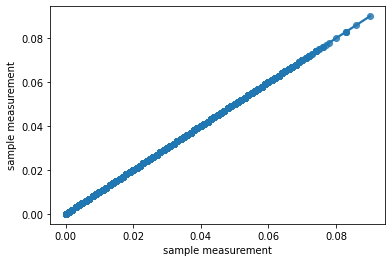

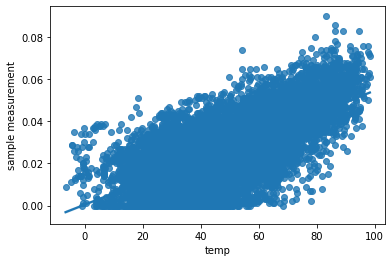

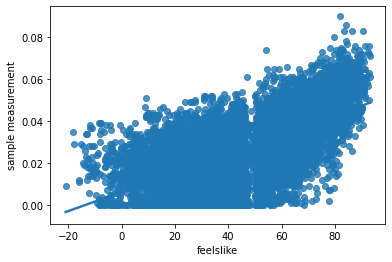

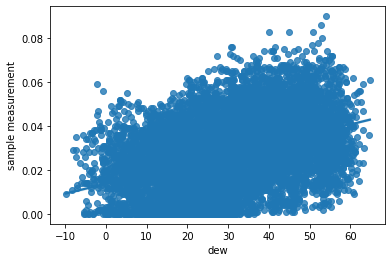

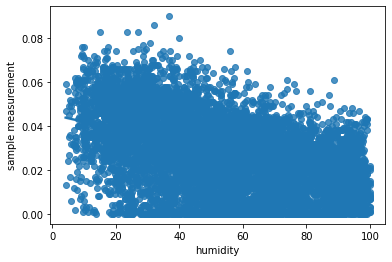

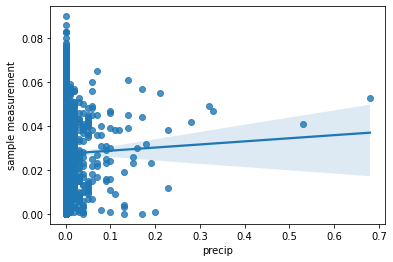

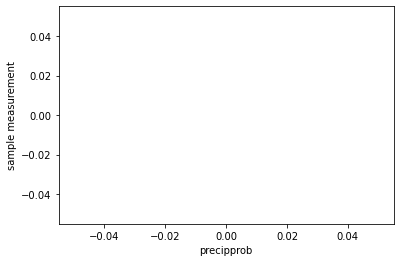

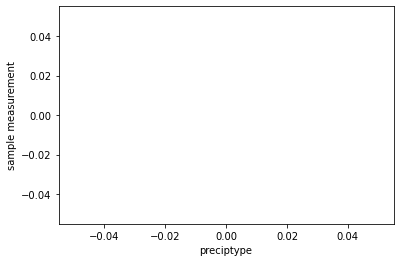

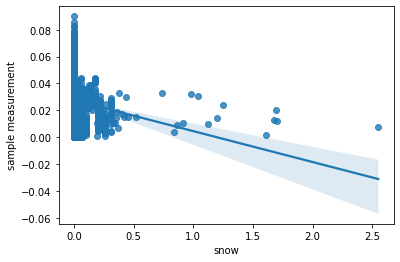

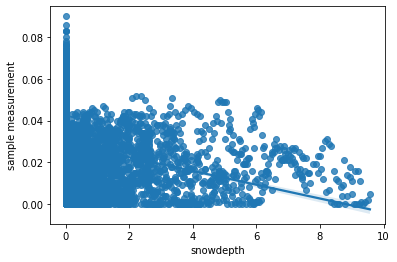

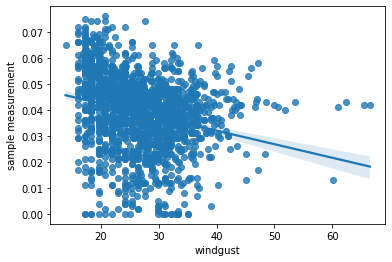

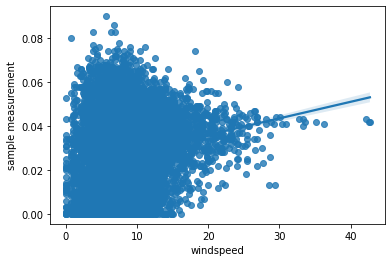

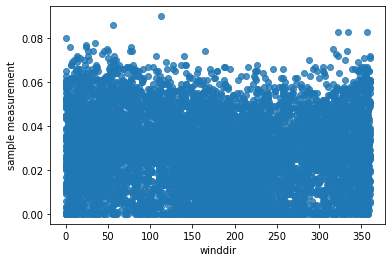

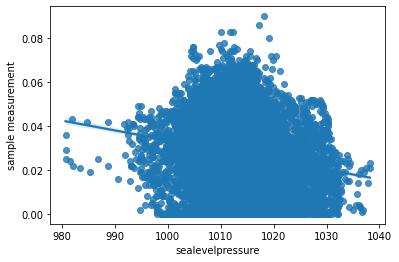

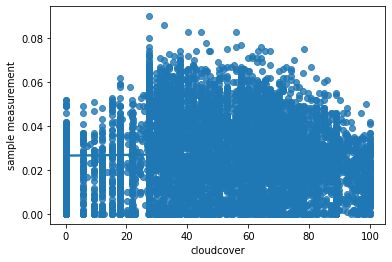

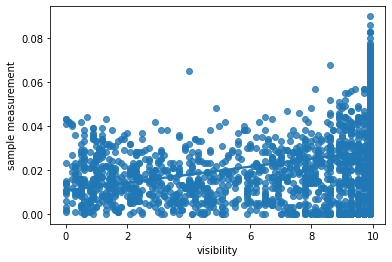

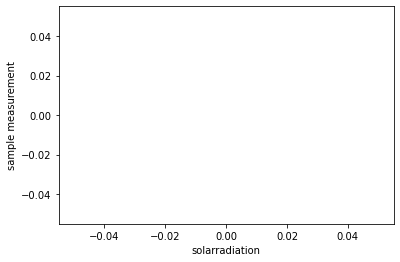

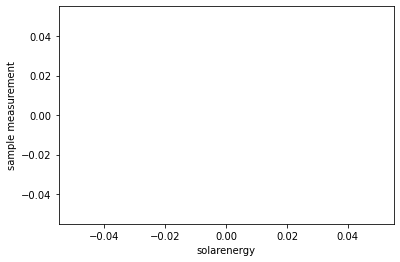

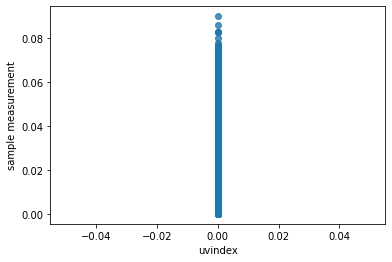

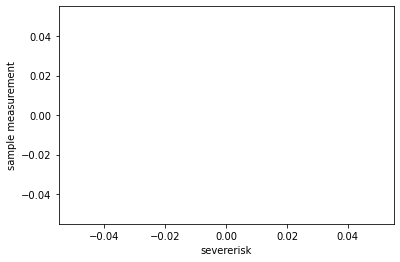

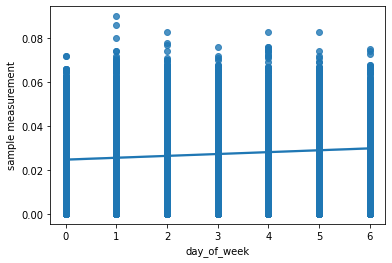

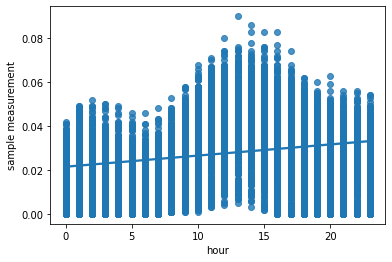

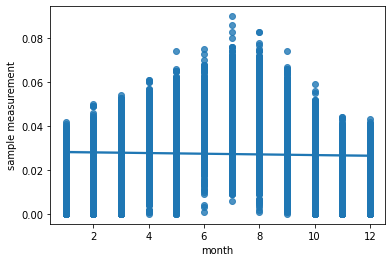

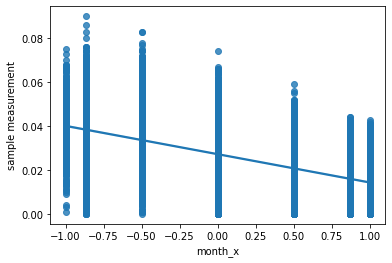

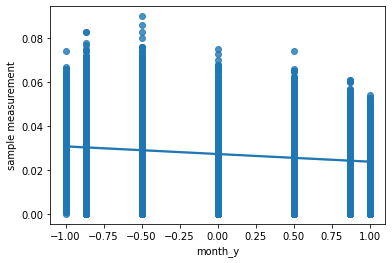

In [104]:
numer_cols = [i for i in df_col.columns if df_col[i].dtype=='float64']
for i in numer_cols:
    plt.figure(i)
    ax = sns.regplot(x=i, y='sample measurement', data = df_col)

In [105]:
calculate_percent_missing(df_col)

,percent_missing
date local,0.000000
time local,0.000000
sample measurement,0.000000
datetime_oz,0.000000
name,0.011574
datetime_weather,0.011574
temp,0.011574
feelslike,0.011574
dew,0.011574
humidity,0.011574


In [64]:
df_col.head()

,datetime_weather,temp,humidity,precip,windspeed,sealevelpressure
0,2019-01-01T00:00:00,0.9,88.81,0.0,5.2,1030.8
1,2019-01-01T01:00:00,0.1,86.21,0.0,4.9,1030.9
2,2019-01-01T02:00:00,0.2,86.25,0.0,5.4,1031.2
3,2019-01-01T03:00:00,0.5,85.95,0.0,7.1,1030.5
4,2019-01-01T04:00:00,0.4,85.06,0.0,7.6,1029.6


In [138]:
use_cols_numerical=['temp', 'humidity', 'snow', 'windspeed', 'month_x', 'month_y']
use_cols_cat = ['type of day']
target='sample measurement'
df_col_useful = df_col[use_cols_numerical + use_cols_cat + [target]]

In [139]:
calculate_percent_missing(df_col_useful)

,percent_missing
temp,0.011574
humidity,0.011574
snow,0.011574
windspeed,0.011574
month_x,0.011574
month_y,0.011574
type of day,0.000000
sample measurement,0.000000


In [140]:
df_col_useful = df_col_useful.dropna()

In [141]:
df_use_num = df_col_useful[use_cols_numerical]
df_use_cat = df_col_useful[use_cols_cat]
y = df_col_useful[target]

In [142]:
df_col_useful = df_col_useful.dropna()

In [143]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler #scaling the parameters
ss = StandardScaler()
df_scaled = pd.DataFrame(ss.fit_transform(df_use_num), index=df_use_num.index, columns=use_cols_numerical)
#pd.pivot_table(df_scaled, index=['diabetes'],  values = df_scaled.columns, aggfunc = np.mean)

In [144]:
df_cat_encoded = pd.get_dummies(df_use_cat, drop_first = True)
df_cat_encoded

,type of day_weekend
0,0
1,0
2,0
3,0
4,0
...,...
8635,0
8636,0
8637,0
8638,0


In [145]:
X = pd.concat([df_scaled, df_cat_encoded], axis=1)


In [146]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.5398927024538195

In [147]:
y_pred = reg.predict(X)
mae = np.abs(y - y_pred)
mae.mean()

0.009286071357907079